In [25]:
import pandas as pd
import numpy as np
import ast
import itertools

import seaborn as sns
import matplotlib.pyplot as plt


### Loading Data

In [2]:
ia_A_path = "full/ia_A.csv"
df_A = pd.read_csv(ia_A_path)

In [3]:
fix_A_path = "full/fixations_A.csv"
df_fix_A = pd.read_csv(fix_A_path)

C:\Users\deeth\AppData\Local\Temp\ipykernel_16872\878136727.py:2: DtypeWarning: Columns (37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fix_A = pd.read_csv(fix_A_path)


### Data Preprocessing

In [210]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

article_col='article_id'
difficulty_col='difficulty_level'
batch_col='article_batch'
paragraph_col='paragraph_id'

df_A_filtered['text_id'] = (
    df_A_filtered[article_col].astype(str) + '_' +
    df_A_filtered[difficulty_col].astype(str) + '_' +
    df_A_filtered[batch_col].astype(str) + '_' +
    df_A_filtered[paragraph_col].astype(str)
)

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True].copy()
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False].copy()

C:\Users\deeth\AppData\Local\Temp\ipykernel_16872\1320471520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A_filtered['text_id'] = (


In [208]:
df_fix_filtered = df_fix_A[(df_fix_A['repeated_reading_trial'] == False) & ((df_fix_A['practice_trial'] == False))]

df_fix_hunters = df_fix_filtered[df_fix_filtered['question_preview'] == True].copy()
df_fix_gatherers = df_fix_filtered[df_fix_filtered['question_preview'] == False].copy()

In [211]:
def get_fix_columns(df):
    df_fix_seq = (
        df.groupby(['participant_id', 'TRIAL_INDEX'], sort=False)
        .agg({
            'CURRENT_FIX_INTEREST_AREA_INDEX': lambda x: tuple(x),
            'CURRENT_FIX_DURATION': lambda x: tuple(x),
        })
        .reset_index()
        .rename(columns={
            'CURRENT_FIX_INTEREST_AREA_INDEX': 'fix_seq',
            'CURRENT_FIX_DURATION': 'fix_duration'
        })
        )

    def remove_consecutive_duplicates_with_duration(seq, durations):
        short_seq = []
        short_durations = []
        for fixation, group in itertools.groupby(zip(seq, durations), key=lambda x: x[0]):
            total_duration = sum(item[1] for item in group)
            short_seq.append(fixation)
            short_durations.append(total_duration)
        return tuple(short_seq), tuple(short_durations)

    df_fix_seq[['short_fix_seq', 'short_fix_duration']] = df_fix_seq.apply(
        lambda row: pd.Series(remove_consecutive_duplicates_with_duration(row['fix_seq'], row['fix_duration'])),
        axis=1
        )
    return df_fix_seq

In [212]:
df_h_fix = get_fix_columns(df_fix_hunters)
df_g_fix = get_fix_columns(df_fix_gatherers)

In [213]:
df_A_hunters = df_A_hunters.merge(df_h_fix, on=['TRIAL_INDEX', 'participant_id'], how='left')
df_A_gatherers = df_A_gatherers.merge(df_g_fix, on=['TRIAL_INDEX', 'participant_id'], how='left')

In [214]:
df_A_hunters[['fix_seq', 'fix_duration', 'short_fix_seq', 'short_fix_duration']]

,fix_seq,fix_duration,short_fix_seq,short_fix_duration
0,"(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ..."
1,"(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ..."
2,"(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ..."
3,"(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ..."
4,"(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(2, 5, 8, 9, 6, 20, 24, 23, 28, 27, 14, 13, 15...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ..."
...,...,...,...,...
380345,"(0, 0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, ...","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, 0, ...","(138, 161, 201, 72, 383, 300, 171, 216, 196, 2..."
380346,"(0, 0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, ...","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, 0, ...","(138, 161, 201, 72, 383, 300, 171, 216, 196, 2..."
380347,"(0, 0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, ...","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, 0, ...","(138, 161, 201, 72, 383, 300, 171, 216, 196, 2..."
380348,"(0, 0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, ...","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(0, 13, 16, 0, 18, 25, 26, 31, 27, 30, 33, 0, ...","(138, 161, 201, 72, 383, 300, 171, 216, 196, 2..."


In [9]:
# df_A_gatherers[df_A_gatherers['short_fix_seq'] != df_A_gatherers['INTEREST_AREA_FIXATION_SEQUENCE'].apply(ast.literal_eval)][['INTEREST_AREA_FIXATION_SEQUENCE', 'short_fix_seq']]

### Creating Features

In [215]:
def create_area_screen_loc(df):
    df = df.copy()
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['1_tokens'] = df['answer_1'].str.split()
    df['2_tokens'] = df['answer_2'].str.split()
    df['3_tokens'] = df['answer_3'].str.split()
    df['4_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['1_len'] = df['1_tokens'].apply(len)
    df['2_len'] = df['2_tokens'].apply(len)
    df['3_len'] = df['3_tokens'].apply(len)
    df['4_len'] = df['4_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        first_len = group['1_len'].iloc[0]
        second_len = group['2_len'].iloc[0]
        third_len = group['3_len'].iloc[0]
        fourth_len = group['4_len'].iloc[0]

        q_end = q_len - 1
        first_end = q_len + first_len - 1
        second_end = q_len + first_len + second_len - 1
        third_end = q_len + first_len + second_len + third_len - 1
        fourth_end = q_len + first_len + second_len + third_len + fourth_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= first_end),
            (index_id > first_end) & (index_id <= second_end),
            (index_id > second_end) & (index_id <= third_end),
            (index_id > third_end) & (index_id <= fourth_end)
        ]

        choices = ['question', 'answer_0', 'answer_1', 'answer_2', 'answer_3']
        group['area_screen_loc'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [216]:
def create_area_label(df):
    def get_screen_loc(row):
        if row['area_screen_loc'] == 'question':
            return 'question'
        elif row['area_screen_loc'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            idx = int(row['area_screen_loc'].split('_')[1])
            return f'answer_{answers_order[idx]}'
        return None

    df['area_label'] = df.apply(get_screen_loc, axis=1)
    return df

In [217]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_area_screen_loc,
    create_area_label,
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_area_screen_loc at 0x000001FFEE2113F0>
<function create_area_label at 0x0000020288F4FD90>
<function create_area_screen_loc at 0x000001FFEE2113F0>
<function create_area_label at 0x0000020288F4FD90>


In [218]:
def create_fixation_sequence_tags(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        label_sequence = []
        location_sequence = []

        for ia_id in sequence:
            if ia_id in group_ids:
                label_sequence.append(id_to_label[ia_id])
                location_sequence.append(id_to_location[ia_id])
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label': tuple(label_sequence[1:]),
            'fix_by_loc': tuple(location_sequence[1:])
        })

    return pd.DataFrame(result)

In [219]:
def create_simplified_fixation_tags(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        durations = group['short_fix_duration'].iloc[0]

        valid_fixations = []
        for ia_id, dur in zip(sequence, durations):
            if ia_id not in group_ids:
                continue
            valid_fixations.append((ia_id, id_to_label[ia_id], id_to_location[ia_id], dur))

        simpl_labels = []
        simpl_locations = []
        simpl_durations = []

        for label, group_iter in itertools.groupby(valid_fixations, key=lambda x: x[1]):
            group_list = list(group_iter)
            simpl_labels.append(label)
            simpl_locations.append(group_list[0][2])
            sum_duration = sum(item[3] for item in group_list)
            simpl_durations.append(sum_duration)

        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'simpl_fix_by_label': tuple(simpl_labels[1:]),
            'simpl_fix_by_loc': tuple(simpl_locations[1:]),
            'simpl_fix_duration': tuple(simpl_durations[1:])
        })

    return pd.DataFrame(result)


In [220]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(result_df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [221]:
per_row_feature_generators = [
    (create_fixation_sequence_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_simplified_fixation_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),

]

In [222]:
df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_fixation_sequence_tags at 0x000001FFEE212200>
<function create_simplified_fixation_tags at 0x000001FFEDF38670>
<function create_fixation_sequence_tags at 0x000001FFEE212200>
<function create_simplified_fixation_tags at 0x000001FFEDF38670>


In [223]:
df_with_features_h[['simpl_fix_duration', 'simpl_fix_by_loc', 'fix_duration', 'fix_by_loc']]

,simpl_fix_duration,simpl_fix_by_loc,fix_duration,fix_by_loc
0,"(660, 516, 245, 413, 351, 945, 551, 1218, 617)","(answer_0, answer_2, answer_3, answer_1, answe...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(answer_0, answer_0, answer_0, answer_0, answe..."
1,"(660, 516, 245, 413, 351, 945, 551, 1218, 617)","(answer_0, answer_2, answer_3, answer_1, answe...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(answer_0, answer_0, answer_0, answer_0, answe..."
2,"(660, 516, 245, 413, 351, 945, 551, 1218, 617)","(answer_0, answer_2, answer_3, answer_1, answe...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(answer_0, answer_0, answer_0, answer_0, answe..."
3,"(660, 516, 245, 413, 351, 945, 551, 1218, 617)","(answer_0, answer_2, answer_3, answer_1, answe...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(answer_0, answer_0, answer_0, answer_0, answe..."
4,"(660, 516, 245, 413, 351, 945, 551, 1218, 617)","(answer_0, answer_2, answer_3, answer_1, answe...","(165, 184, 157, 164, 155, 225, 107, 184, 130, ...","(answer_0, answer_0, answer_0, answer_0, answe..."
...,...,...,...,...
380345,"(1101, 1833, 1714, 314)","(answer_1, answer_2, answer_3, answer_1)","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(answer_0, answer_0, answer_1, answer_1, answe..."
380346,"(1101, 1833, 1714, 314)","(answer_1, answer_2, answer_3, answer_1)","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(answer_0, answer_0, answer_1, answer_1, answe..."
380347,"(1101, 1833, 1714, 314)","(answer_1, answer_2, answer_3, answer_1)","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(answer_0, answer_0, answer_1, answer_1, answe..."
380348,"(1101, 1833, 1714, 314)","(answer_1, answer_2, answer_3, answer_1)","(33, 105, 161, 201, 72, 383, 300, 171, 216, 19...","(answer_0, answer_0, answer_1, answer_1, answe..."


### Distance measure

#### 1. Self made

In [255]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import hdbscan
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import leaves_list
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

from Bio import pairwise2

In [256]:
def sequence_distance_dummy(item1, item2, dist=1):
    m = 0.83

    fix_seq1, fix_dur1 = item1
    fix_seq2, fix_dur2 = item2

    fix_seq1, fix_dur1 = list(fix_seq1), list(fix_dur1)
    fix_seq2, fix_dur2 = list(fix_seq2), list(fix_dur2)

    max_len = max(len(fix_seq1), len(fix_seq2))

    if len(fix_seq1) < max_len:
        fix_seq1 = fix_seq1 + [0] * (max_len - len(fix_seq1))
        fix_dur1 = fix_dur1 + [0] * (max_len - len(fix_dur1))
    if len(fix_seq2) < max_len:
        fix_seq2 = fix_seq2 + [0] * (max_len - len(fix_seq2))
        fix_dur2 = fix_dur2 + [0] * (max_len - len(fix_dur2))

    total_distance = 0
    for s1, d1, s2, d2 in zip(fix_seq1, fix_dur1, fix_seq2, fix_dur2):
        if s1 == s2:
            total_distance += abs(d1 - d2) * (m**dist)
        else:
            total_distance += (d1 + d2) * (m**dist)

    return total_distance

In [316]:
def sequence_distance(item1, item2, dist=1):
    m = 0.83

    fix_seq1, fix_dur1 = item1
    fix_seq2, fix_dur2 = item2

    fix_seq1, fix_dur1 = list(fix_seq1), list(fix_dur1)
    fix_seq2, fix_dur2 = list(fix_seq2), list(fix_dur2)

    if not fix_seq1:
        fix_seq1 = [0]
        fix_dur1 = [0]
    if not fix_seq2:
        fix_seq2 = [0]
        fix_dur2 = [0]

    alignments = pairwise2.align.globalxx(fix_seq1, fix_seq2,gap_char=['-'])
    best_alignment = alignments[0]
    aln_tokens1 = best_alignment[0]
    aln_tokens2 = best_alignment[1]

    aligned_dur1 = []
    aligned_dur2 = []
    idx1 = 0
    idx2 = 0

    for token_a, token_b in zip(aln_tokens1, aln_tokens2):
        if token_a == "-":
            aligned_dur1.append(0)
        else:
            aligned_dur1.append(fix_dur1[idx1])
            idx1 += 1

        if token_b == "-":
            aligned_dur2.append(0)
        else:
            aligned_dur2.append(fix_dur2[idx2])
            idx2 += 1

    # print(f'1tok: {aln_tokens1}')
    # print(f'1dur: {aligned_dur1}')
    # print(f'2tok: {aln_tokens2}')
    # print(f'2dur: {aligned_dur2}')
    # print('------------------------------')

    total_distance = 0
    for s1, d1, s2, d2 in zip(aln_tokens1, aligned_dur1, aln_tokens2, aligned_dur2):
        if s1 == s2:
            total_distance += abs(d1 - d2) * (m**dist)
        else:
            total_distance += (d1 + d2) * (m**dist)

    return total_distance

### Clustering

In [258]:
def seq_cluster_kmeans(df, seq_col, dur_col, distance_func=sequence_distance, n_clusters=5, mds_components=30):
    items = df.apply(lambda row: (row[seq_col], row[dur_col]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    mds = MDS(n_components=mds_components, dissimilarity='precomputed')
    mds_embedding = mds.fit_transform(distance_matrix)

    kmeans_clusterer = KMeans(n_clusters=n_clusters)
    labels = kmeans_clusterer.fit_predict(mds_embedding)

    return distance_matrix, labels

In [259]:
def seq_cluster_agglomerative(df, seq_col, dur_col, distance_func=sequence_distance, n_clusters=5):
    items = df.apply(lambda row: (row[seq_col], row[dur_col]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    clusterer = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, metric='precomputed')
    labels = clusterer.fit_predict(distance_matrix)
    return distance_matrix, labels


In [260]:
def seq_cluster_dbscan(df, seq_col, dur_col, distance_func=sequence_distance, eps=0.99, min_samples=2):
    items = df.apply(lambda row: (row[seq_col], row[dur_col]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = clusterer.fit_predict(distance_matrix)

    return distance_matrix, labels

In [261]:
def seq_cluster_hdbscan(df, seq_col, dur_col, distance_func=sequence_distance, min_cluster_size=2):
    items = df.apply(lambda row: (row[seq_col], row[dur_col]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(distance_matrix)

    return distance_matrix, labels

### Clustering Visualization

In [262]:
def plot_custom_dendrogram(distance_matrix, subset, tid, seq_col):
    linkage_matrix = linkage(distance_matrix, method='average')
    custom_labels = [", ".join(map(str, seq)) for seq in subset[seq_col]]

    plt.figure(figsize=(12, 6))
    plt.title(f"Dendrogram for text_id: {tid}")
    dendrogram(linkage_matrix, labels=custom_labels,
               leaf_rotation=90,
               leaf_font_size=10)
    plt.xlabel(f"Fixation Sequences ({seq_col}])")
    plt.ylabel("Distance")
    plt.show()

In [263]:
def cluster_by_text(df, tid, seq_col, dur_col, dist_func=sequence_distance, clusterer=seq_cluster_agglomerative):
    subset = df[df['text_id'] == tid]
    print(f"\n=== Processing text_id: {tid} ===")

    distance_matrix, labels = clusterer(subset, seq_col, dur_col, distance_func=dist_func)
    condensed_distance = squareform(distance_matrix)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(distance_matrix)

    plt.figure(figsize=(8,6))
    plt.title(f"PCA Projection for text_id: {tid}")
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='plasma')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

    linkage_matrix = linkage(condensed_distance, method='average')
    leaf_order = leaves_list(linkage_matrix)
    reordered_matrix = distance_matrix[leaf_order][:, leaf_order]

    plt.figure(figsize=(8, 6))
    plt.title(f"Reordered Distance Matrix for text_id: {tid}")
    im = plt.imshow(reordered_matrix, cmap='viridis', interpolation='nearest')
    plt.xlabel("Reordered Index")
    plt.ylabel("Reordered Index")
    plt.colorbar(im)
    plt.show()

    plot_custom_dendrogram(condensed_distance, subset, tid, seq_col)


=== Processing text_id: 10_Ele_1_2 ===


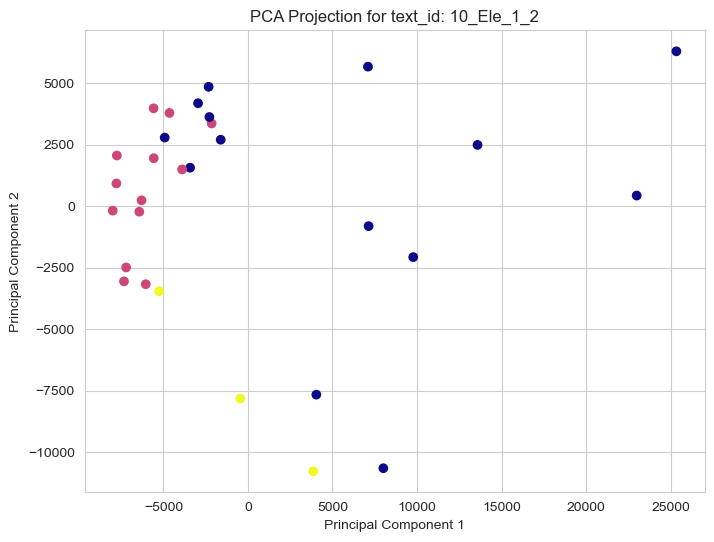

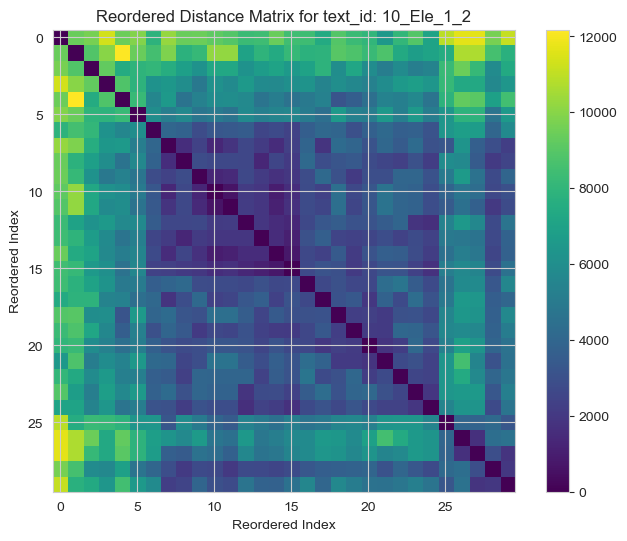

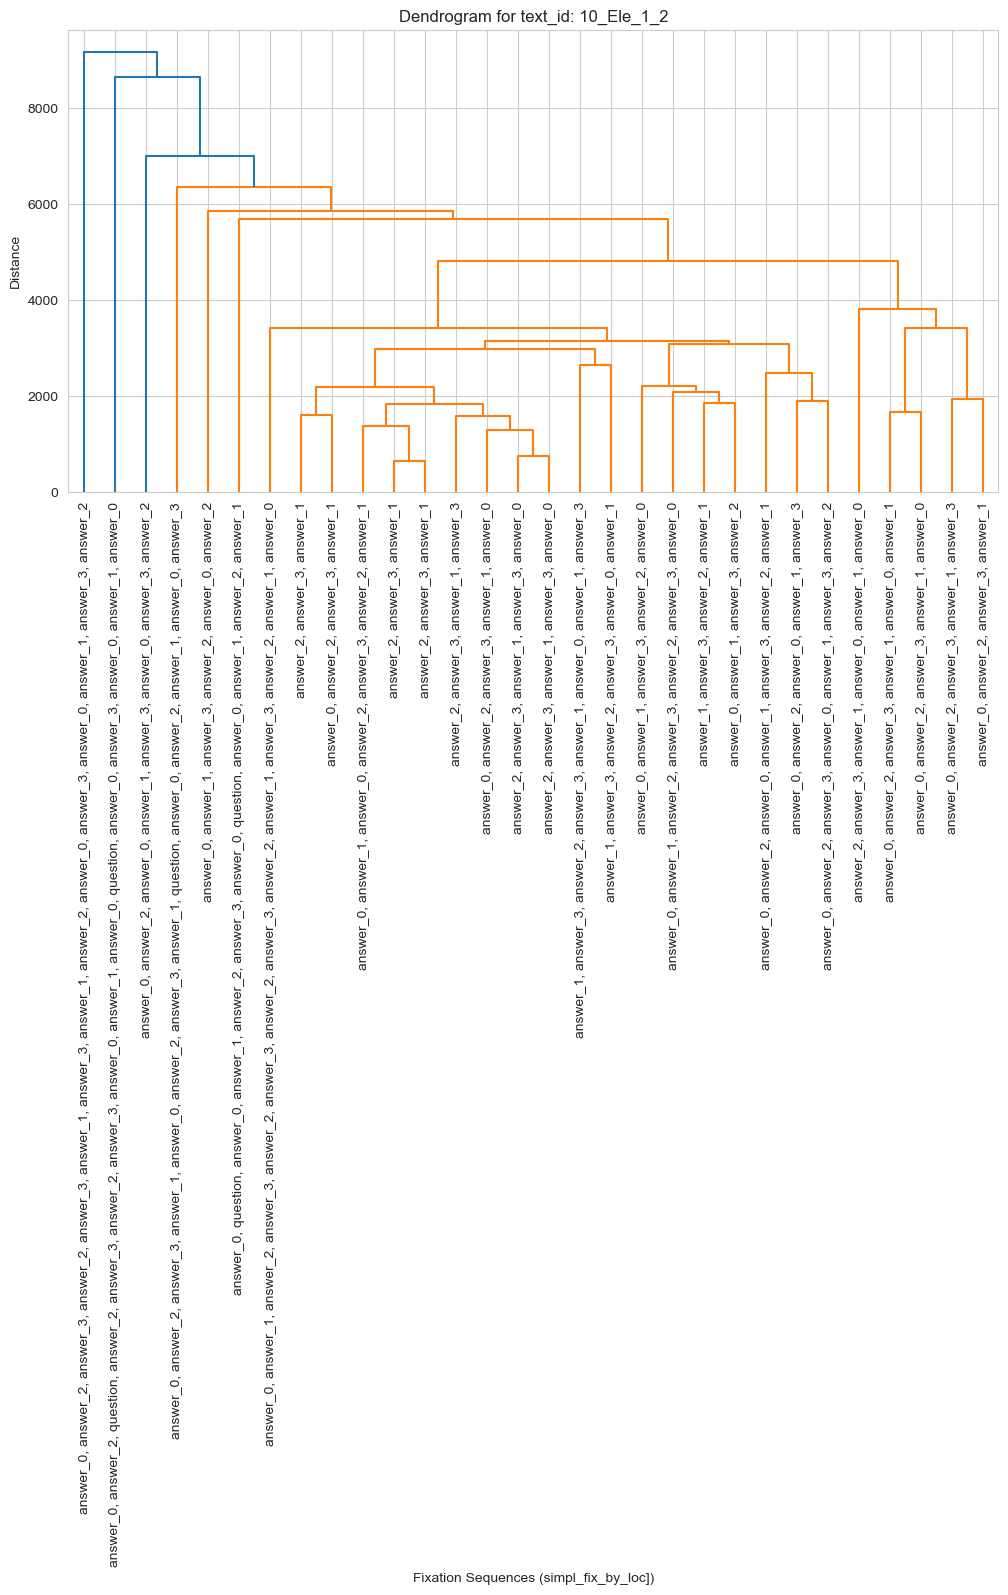

In [318]:
def get_random_text_id(df: pd.DataFrame):
    return df['text_id'].sample(n=1).iloc[0]

seq_col = 'simpl_fix_by_loc'
dur_col = 'simpl_fix_duration'

h_rows = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', seq_col, dur_col]].drop_duplicates()

tid = get_random_text_id(h_rows)
cluster_by_text(h_rows, tid, seq_col, dur_col, dist_func=sequence_distance,clusterer=seq_cluster_hdbscan)